In [1]:
RANDOM_SEED = 42

In [2]:
path_ = "Scalograms-rest-stacked-wavdec"

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

d:\Tools\Anaconda\envs\tensorflow-gpu\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\Tools\Anaconda\envs\tensorflow-gpu\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
d:\Tools\Anaconda\envs\tensorflow-gpu\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
d:\Tools\Anaconda\envs\tensorflow-gpu\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
d:\Tools\Anaconda\envs\tensorflow-gpu\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [4]:
#Preparing images for model training --- image size = 256 x 256
train_batch = 64
test_batch = 64
train_set= image_dataset_from_directory(path_,
                                labels='inferred',
                                label_mode='binary',
                                batch_size=train_batch,
                                seed=RANDOM_SEED,
                                shuffle=True,
                                validation_split=0.2,
                                subset='training')
                                
val_set =  image_dataset_from_directory(path_,
                                labels='inferred',
                                label_mode='binary',
                                batch_size=test_batch,
                                seed=RANDOM_SEED,
                                shuffle=True,
                                validation_split=0.2,
                                subset='validation')

Found 1680 files belonging to 2 classes.
Using 1344 files for training.
Found 1680 files belonging to 2 classes.
Using 336 files for validation.


In [5]:
test_ds_size = int(int(val_set.__len__()) * 0.5) # test-test set has 478 images and val set has 1647 images == # 9563 * 0.05
test_test_set = val_set.take(test_ds_size)
test_set = val_set.skip(test_ds_size)  

In [6]:
print(val_set.__len__(), train_set.__len__(), test_set.__len__(), test_test_set.__len__(), sep='\n')

tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(21, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)


In [7]:
#from livelossplot import PlotLossesKeras
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, AveragePooling2D, BatchNormalization, Dropout, Conv3D, InputLayer, MaxPooling3D
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras import regularizers, initializers
from livelossplot import PlotLossesKeras

In [8]:
cnn_3d = Sequential([
        # Set input layer
        InputLayer(input_shape=(256, 256,256,3)),

        # Conv + Maxpooling
        Conv3D(6, (3, 3, 3), padding="same", activation="relu"),
        MaxPooling3D(pool_size=(2, 2, 2)),

        Conv3D(6, (3, 3, 3), padding="same", activation="relu"),
        MaxPooling3D(pool_size=(2, 2, 2)),

        # Normalization
        BatchNormalization(),

        # Flatten to 1D
        Flatten(),

        Dense(16, activation="relu"),

        Dropout(0.5),

        Dense(8, activation="relu"),


        # Sigmoid
        Dense(1, activation="sigmoid")
    ])

In [9]:
cnn_3d.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 256, 256, 256, 6)  492       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 128, 128, 128, 6)  0        
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 128, 128, 128, 6)  978       
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 64, 64, 64, 6)    0         
 3D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64, 6)    24        
 ormalization)                                                   
                                                        

In [10]:
model_1 = Sequential()

model_1.add(Conv2D(8,(3,3),input_shape=(256,256,3),activation='relu', kernel_initializer=initializers.HeNormal(), kernel_regularizer=regularizers.L2(0.01), padding='same'))
model_1.add(AveragePooling2D(pool_size=(2, 2)))
model_1.add(BatchNormalization())

model_1.add(Conv2D(8,(3,3),activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model_1.add(AveragePooling2D(pool_size=(2, 2)))
model_1.add(BatchNormalization())

model_1.add(Flatten())

model_1.add(Dense(64,activation='relu', kernel_regularizer=regularizers.L2(0.5)))

model_1.add(Dense(32,activation='relu', kernel_regularizer=regularizers.L2(0.5)))

model_1.add(Dense(1,activation='sigmoid'))

model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','Recall','Precision','AUC'])   

In [11]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 8)       224       
                                                                 
 average_pooling2d (AverageP  (None, 128, 128, 8)      0         
 ooling2D)                                                       
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 8)      32        
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 8)       584       
                                                                 
 average_pooling2d_1 (Averag  (None, 63, 63, 8)        0         
 ePooling2D)                                                     
                                                      

In [10]:
filepath = "Models/rest-scalogram-base-model-checkpoints/rest-scalogram-base-model-3.h5"

callbacks = [#EarlyStopping(monitor='val_accuracy', patience=4),
            ModelCheckpoint(filepath=filepath, monitor="val_accuracy", mode='max', save_best_only=True),
            PlotLossesKeras()]

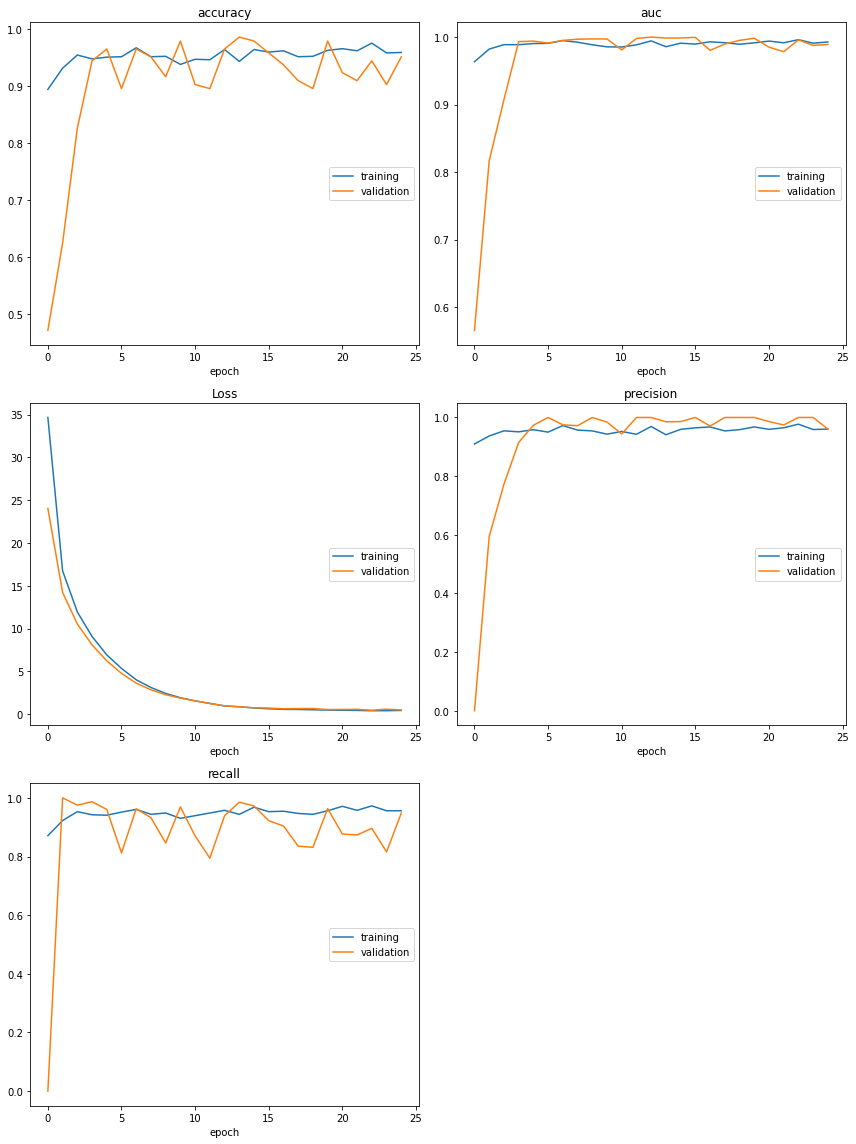

accuracy
	training         	 (min:    0.894, max:    0.975, cur:    0.959)
	validation       	 (min:    0.472, max:    0.986, cur:    0.951)
auc
	training         	 (min:    0.963, max:    0.996, cur:    0.993)
	validation       	 (min:    0.566, max:    1.000, cur:    0.989)
Loss
	training         	 (min:    0.395, max:   34.661, cur:    0.429)
	validation       	 (min:    0.451, max:   24.032, cur:    0.484)
precision
	training         	 (min:    0.910, max:    0.977, cur:    0.960)
	validation       	 (min:    0.000, max:    1.000, cur:    0.961)
recall
	training         	 (min:    0.871, max:    0.973, cur:    0.956)
	validation       	 (min:    0.000, max:    1.000, cur:    0.948)
21/21 [==============================] - 21s 1s/step - loss: 0.4285 - accuracy: 0.9591 - recall: 0.9560 - precision: 0.9604 - auc: 0.9926 - val_loss: 0.4836 - val_accuracy: 0.9514 - val_recall: 0.9481 - val_precision: 0.9605 - val_auc: 0.9890


In [11]:
h = model_1.fit(train_set,
                epochs=25,
                #steps_per_epoch=64,
                validation_data=test_set,
                #validation_steps=32,
                callbacks=callbacks
                )

In [10]:
filepath = "Models/rest-scalogram-base-model-checkpoints/rest-scalogram-base-model-2.h5"

callbacks = [#EarlyStopping(monitor='val_accuracy', patience=4),
            ModelCheckpoint(filepath=filepath, monitor="val_accuracy", mode='max', save_best_only=True),
            PlotLossesKeras()]

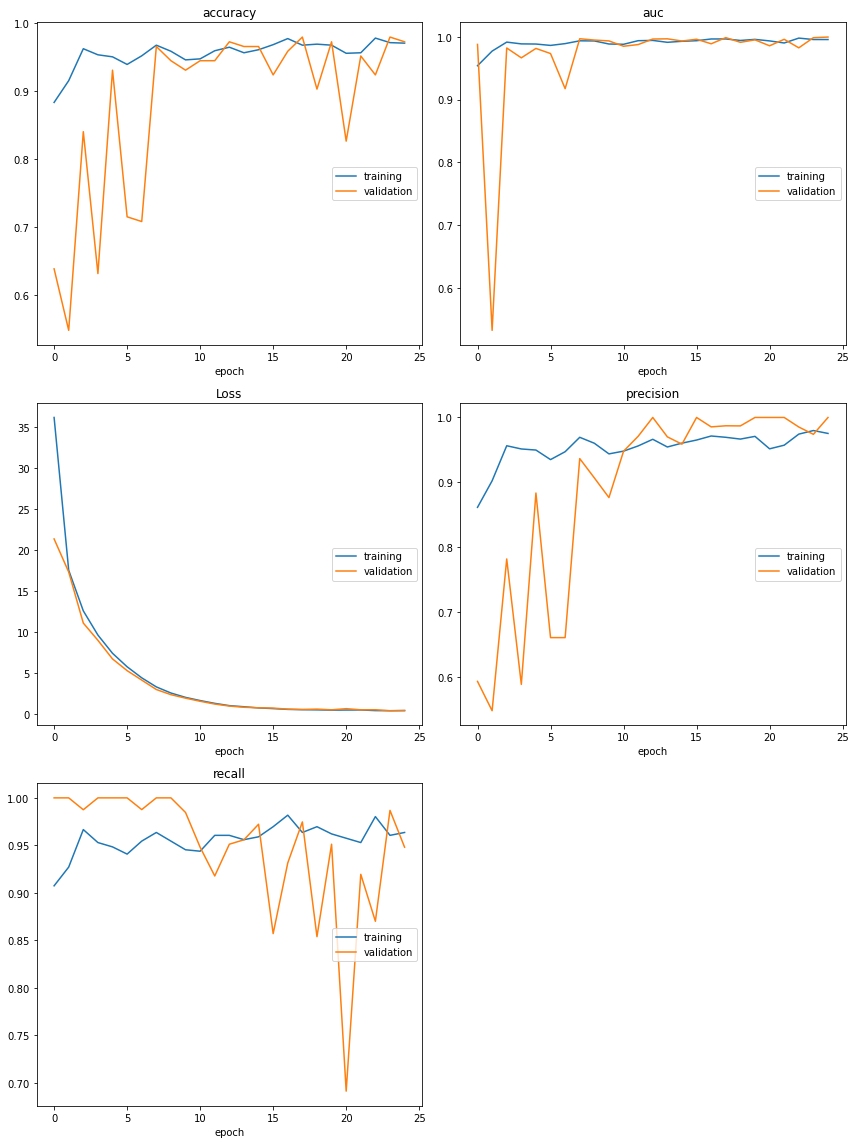

accuracy
	training         	 (min:    0.883, max:    0.978, cur:    0.970)
	validation       	 (min:    0.549, max:    0.979, cur:    0.972)
auc
	training         	 (min:    0.954, max:    0.998, cur:    0.996)
	validation       	 (min:    0.532, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.372, max:   36.176, cur:    0.382)
	validation       	 (min:    0.371, max:   21.346, cur:    0.408)
precision
	training         	 (min:    0.862, max:    0.980, cur:    0.975)
	validation       	 (min:    0.549, max:    1.000, cur:    1.000)
recall
	training         	 (min:    0.907, max:    0.982, cur:    0.964)
	validation       	 (min:    0.691, max:    1.000, cur:    0.948)
21/21 [==============================] - 3s 134ms/step - loss: 0.3819 - accuracy: 0.9702 - recall: 0.9636 - precision: 0.9754 - auc: 0.9957 - val_loss: 0.4081 - val_accuracy: 0.9722 - val_recall: 0.9481 - val_precision: 1.0000 - val_auc: 0.9996


In [11]:
h = model_1.fit(train_set,
                epochs=25,
                #steps_per_epoch=64,
                validation_data=test_set,
                #validation_steps=32,
                callbacks=callbacks
                )

In [13]:
import pandas as pd

pd.DataFrame.from_dict(h.history).to_csv(filepath[:-2] + 'csv' , index=False)
#data=pd.read_csv("Models/scalogram-base-model-checkpoints/scalogram-base-model-1.csv")

In [13]:
model_1.evaluate(test_test_set)

3/3 [==============================] - 0s 56ms/step - loss: 0.4197 - accuracy: 0.9688 - recall: 0.9524 - precision: 0.9901 - auc: 0.9960


[0.419742614030838,
 0.96875,
 0.9523809552192688,
 0.9900990128517151,
 0.9960044026374817]